# 기본설정

In [6]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

# 1. 선형회귀
X: (100, 1) 행렬로 2를 곱하여 0~2 사이의 값을 가짐  

Y: X의 값에 대한 선형관계(4+3*X)를 통해 값을 생성하고, 가우시안노이즈(np.random.randn(100, 1))를 추가하여 데이터에 무작위성을 부여함

In [7]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

linreg_data = np.c_[X, y]
linreg_data[:5]

array([[0.74908024, 6.33428778],
       [1.90142861, 9.40527849],
       [1.46398788, 8.48372443],
       [1.19731697, 5.60438199],
       [0.31203728, 4.71643995]])

그림 저장: generated_data_plot


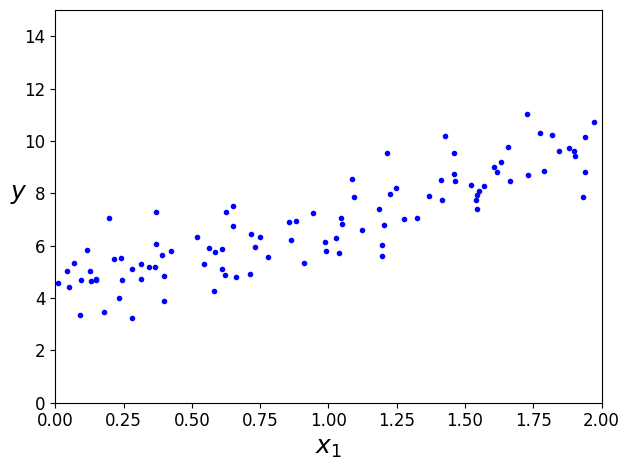

In [8]:
plt.plot(X, y, "b.")                          # 파랑 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)              # x축 표시
plt.ylabel("$y$", rotation=0, fontsize=18)    # y축 표시
plt.axis([0, 2, 0, 15])                       # x축, y축 구간 지정

save_fig("generated_data_plot")
plt.show()

## 정규방정식
선형회귀 모델의 매개변수를 직접 찾는 방법

 θ=(X
T
 X)
−1
 X
T
 y

In [9]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1 추가(편향을 위함)
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

In [10]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) #정규방정식 수식
theta_best

array([[4.21509616],
       [2.77011339]])

In [11]:
X_new = np.array([[0], [2]]) #새로운 데이터 샘플들의 특성 값을 정의
X_new_b = np.c_[np.ones((2, 1)), X_new]  #모든 새로운 샘플에 x0 = 1 추가
X_new_b

array([[1., 0.],
       [1., 2.]])

In [12]:
y_predict = X_new_b.dot(theta_best) #최적의 매개변수 theta_best를 사용하여 새로운 샘플들에 대한 예측 값을 계산
y_predict

array([[4.21509616],
       [9.75532293]])

그림 저장: linear_model_predictions_plot


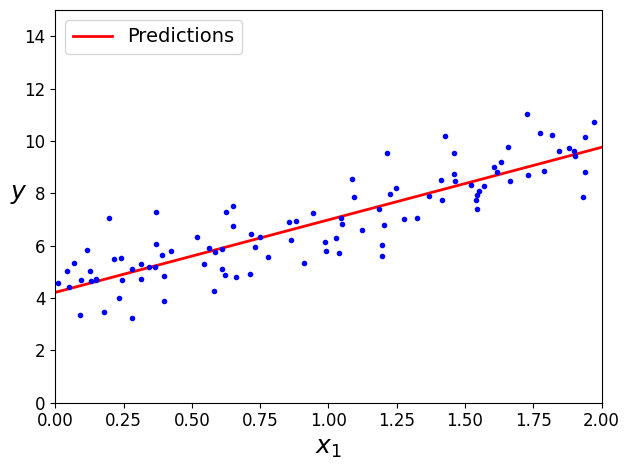

In [13]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions") #빨강 직선. label은 범례 지정용

plt.plot(X, y, "b.")                                               #파란 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.legend(loc="upper left", fontsize=14)                          #범례 위치
plt.axis([0, 2, 0, 15])                                            #x축, y축 구간 지정

save_fig("linear_model_predictions_plot")
plt.show()

## 사이킷런의 LinearRegression 모델

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [15]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

▽ LinearRegression 함수는 scipy.linalg.lstsq() 함수(최소제곱)를 기반으로 함

In [16]:
import scipy
theta_best_svd, residuals, rank, s = scipy.linalg.lstsq(X_b, y)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

▽ np.linalg.pinv() 함수를 사용하여 유사역행렬을 구함

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [18]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# 2. 경사하강법
- 임의의 값으로 시작해서 조금씩 비용 함수가 감소하는 방향으로 진행.
- 알고리즘이 최솟값에 수렴할 때 까지 점진적으로 향상시킴

---

**경사 하강법 중요 파라미터 = 학습률 하이퍼파라미터 = 스텝의 크기**

**경사 하강법 단점: 전역 최솟값 보다 덜 좋은 지역 최솟값에 수렴**

## 배치경사하강법

-> 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산

In [27]:
#배치경사하강법을 이용하여 선형회귀모델의 매개변수 θ값을 학습
eta = 0.1 #학습률
n_iterations = 1000 #경사하강법의 반복 횟수
m = 100 #데이터의 샘플 개수

theta = np.random.randn(2, 1) #매개변수θ의 초기값을 2X1벡터로 무작위로 설정

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) -y)
  theta = theta - eta * gradients

In [28]:
theta

array([[4.21509616],
       [2.77011339]])

## 확률적 경사 하강법

-> 매 스텝에서 한 개의 샘플을 랜덤하게 선택하고, 그 하나의 샘플에 대한 그레이디언트를 계산

- 비용 함수가 매우 불규칙할 때 알고리즘이 지역 최솟값을 건너띄어 전역 최솟값을 찾을 가능성 높음
- 확률적이므로 배치 경사 하강법보다 매우 불안정
- 적은 데이터로 학습 가능, 속도가 빠름

In [24]:
n_epochs = 50
t0, t1 = 5, 50  #학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  #무작위 초기화

# 확률적 경사 하강법 시작
for epoch in range(n_epochs):
    for i in range(m):  #각 에포크에서 데이터셋의 모든 샘플에 대해 반복
        random_index = np.random.randint(m)  #하나의 샘플을 무작위로 선택
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]

        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)  #선택된 샘플에 대한 그래디언트 계산
        eta = learning_schedule(epoch * m + i)  #학습률 계산
        theta = theta - eta * gradients  #계산된 그래디언트와 학습률을 사용하여 매개변수 업데이트


In [25]:
theta

array([[4.18715083],
       [2.731247  ]])

## 미니배치 경사 하강법  
 -> 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산

 - BGD와 SGD의 절충안
 - 파라미터 공간에서 SGD보다 덜 불규칙하게 움직임
 - SGD보다 전역 최솟값에 더 가까이 도달하게 됨(but 지역 최솟값은 빠져 나오기 더 힘들 수 있음)


---

**total_iteration = iterations_per_epochs * n_epochs**

**iterations_per_epochs = m/minibatch**

In [29]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

In [30]:
t = 0

for epoch in range(n_iterations):

    # 에포크가 바뀔 때마다 훈련 데이터 섞기
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    # 20개 데이터 샘플을 훈련할 때마다 파라미터 업데이트
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)        # 학습 스케줄 활용
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [31]:
theta

array([[4.25214635],
       [2.7896408 ]])

# 3. 다항 회귀

- 비선형 데이터를 학습하기 위해 선형 모델을 사용하는 기법
- 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성을 추가 -> 확장된 훈련 데이터에 선형회귀 적용

In [32]:
m = 100
x = 6 * np.random.rand(m,1) -3
y = 0.5 * X**2 + np.random.randn(m, 1)

In [41]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([0.74908024])

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([0.0694551]), array([[-0.41275606,  1.01934144, -0.15375723]]))

그림 저장: quadratic_data_plot


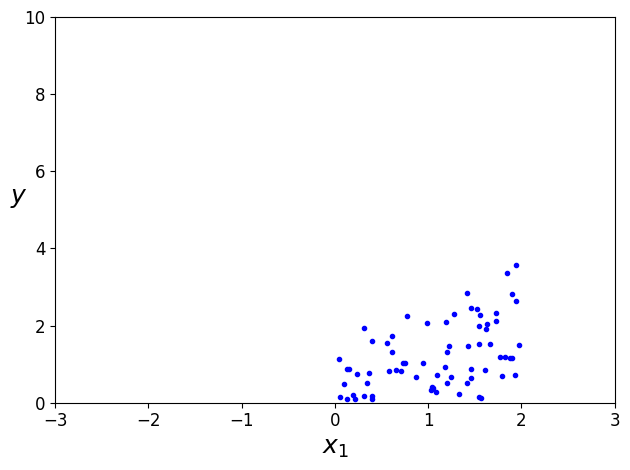

In [43]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

# 4. 학습곡선

 -> 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄

In [44]:
from sklearn.metrics import mean_squared_error           # MSE 수동 계산
from sklearn.model_selection import train_test_split     # 무작위 샘플링

def plot_learning_curves(model, X, y):
    # 8:2 로 분류
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []                    # MSE 추적 장치

    for m in range(1, len(X_train)):                     # m 개의 훈련 샘플을 대상으로 훈련
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        # MSE 기록
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

## 과소적합 학습곡선

**훈련 데이터(빨강)에 대한 성능**

- 훈련 세트가 커지면서 RMSE(평균 제곱근 오차)가 커짐
훈련 세트가 어느 정도 커지면 더 이상 RMSE가 변하지 않음

**검증 데이터(파랑)에 대한 성능**

- 검증 세트에 대한 성능이 훈련 세트에 대한 성능과 거의 비슷해짐

그림 저장: underfitting_learning_curves_plot


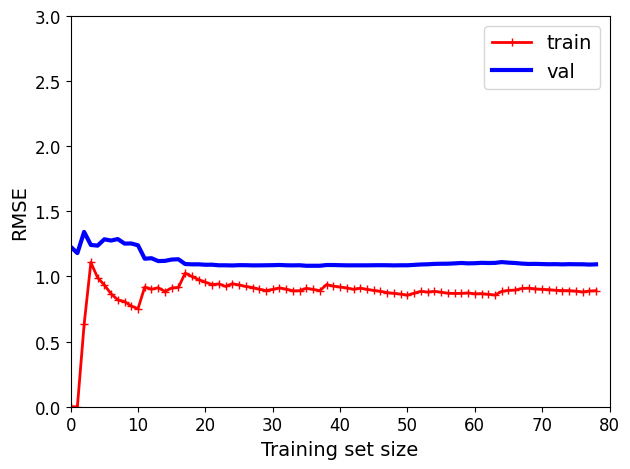

In [45]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

##과대적합 학습곡선

2차 다항식으로 생성된 데이터셋에 대해 10차 다항 회귀를 적용한 선형 회귀 모델의 학습 곡선은 다음과 같으며, 전형적인 과대 적합의 양태를 잘 보여준다.

훈련 데이터(빨강)에 대한 성능: 훈련 데이터에 대한 평균 제곱근 오차가 매우 낮음.

검증 데이터(파랑)에 대한 성능: 훈련 데이터에 대한 성능과 차이가 크게 벌어짐.
과대적합 모델 개선법: 훈련 데이터 추가

그림 저장: high_degree_polynomials_plot


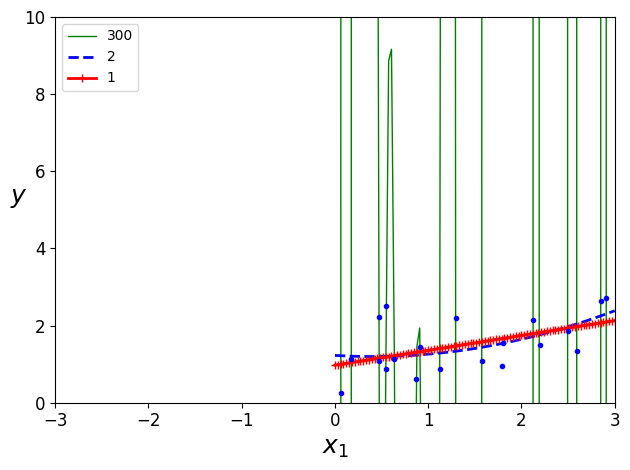

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 세 개의 다항 회귀 모델 지정: 차례 대로 300차 다항 회귀, 2차 다항 회귀, 1차 선형 회귀 모델의 예측값 그래프 그리기
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):

    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)  # 다항 특성 변환기
    std_scaler = StandardScaler()                                             # 표준화 축척 조정
    lin_reg = LinearRegression()                                              # 선형 회귀 모델

    polynomial_regression = Pipeline([                         # 파이프라인: 전처리 + 선형 회귀 모델
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])

    polynomial_regression.fit(X, y)                                            # 훈련
    y_newbig = polynomial_regression.predict(X_new)                            # 예측

    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)       # 그래프 그리기

plt.plot(X, y, "b.", linewidth=3)                                              # 원 데이터 산점도
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

그림 저장: learning_curves_plot


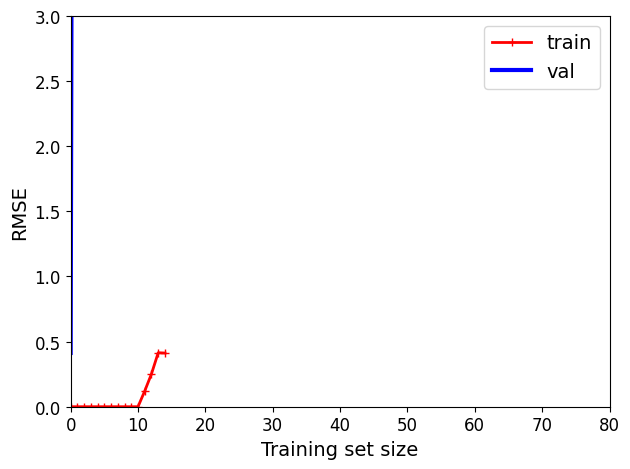

In [52]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")
plt.show()

# 5. 규제가 있는 선형 모델
-> 규제를 통해 과대적합을 방지함
- 릿지회귀
- 라쏘회귀
- 엘라스틱회귀

## 릿지회귀


In [53]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5     # 1차 선형회귀 모델을 따로도록 함. 단, 잡음 추가됨.
X_new = np.linspace(0, 3, 100).reshape(100, 1)    # 0~3 구간에서 균등하게 100개의 검증 데이터 선택

그림 저장: ridge_regression_plot


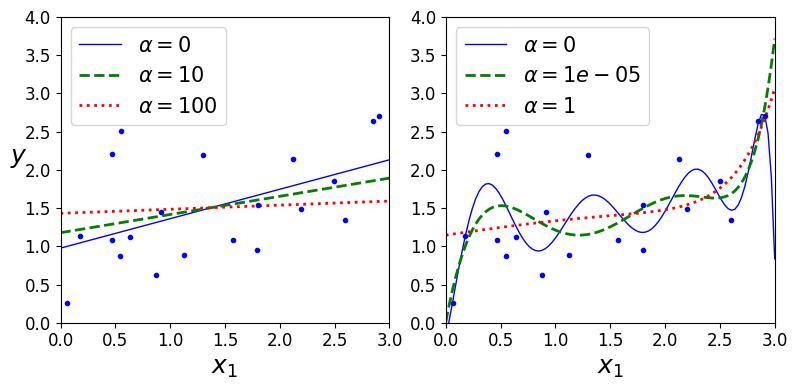

In [54]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),           # 표준화 축척 조정
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

##라쏘회귀



In [55]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

##엘라스틱 넷

In [56]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

#6. 로지스틱회귀

- 확률 모델로서 독립변수의 선형 결합을 이용하여 사건의 발생 가능성을 예측하는데 사용되는 통계 기법
- 0.5를 기준으로 1과 0을 결정

##확률추정

그림 저장: logistic_function_plot


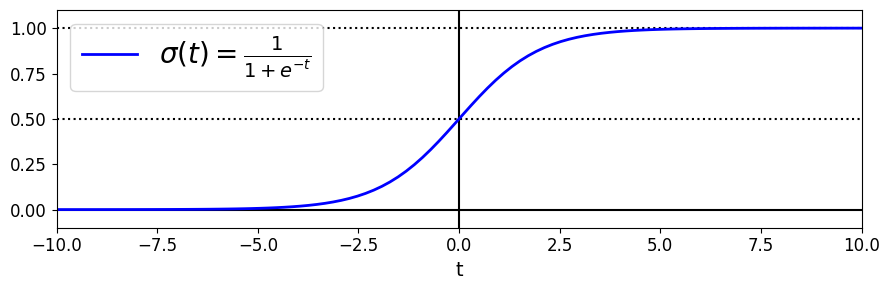

In [58]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

##결정경계(붓꽃데이터)

<ipython-input-59-a9c15b19c1d9>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # 버지니카(Virginica) 품종일 때 1(양성)


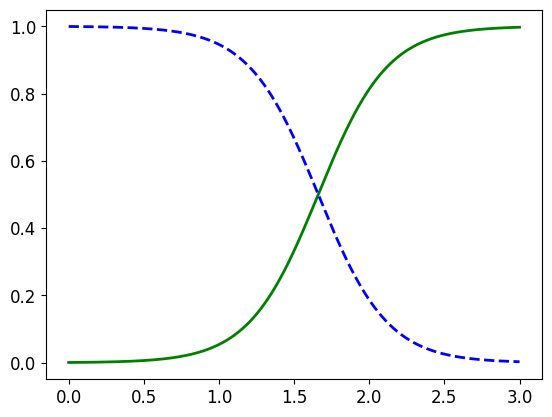

In [59]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris["data"][:, 3:]                   # 1개의 특성(꽃잎 너비)만 사용
y = (iris["target"] == 2).astype(np.int)  # 버지니카(Virginica) 품종일 때 1(양성)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(1000, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

## 소프트맥스 회귀

- 다중 클래스 분류를 지원하도록 한 회귀 모델  
- 다항 로지스틱 회귀라고도 불림

In [60]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

그림 저장: softmax_regression_contour_plot


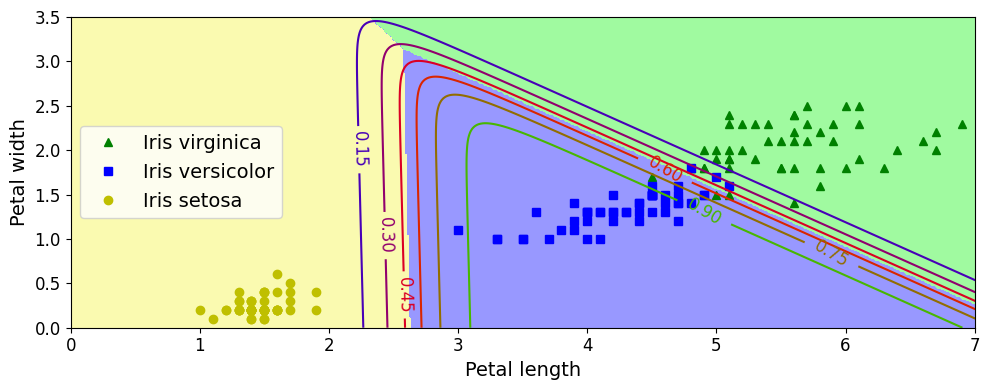

In [61]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()